dataset: https://www.mvtec.com/company/research/datasets/mvtec-ad

In [6]:
import numpy as np
import tensorflow as tf
import keras
from keras.layers import Input, Conv2D, Reshape, MaxPooling2D, GlobalAvgPool2D, Dense, Conv2DTranspose, Cropping2D
from keras.optimizers import Adam
import os

In [8]:
train_path = os.path.join('dataset', 'train_images.npy')
train_images = np.load(train_path)
train_images = train_images / 255.0

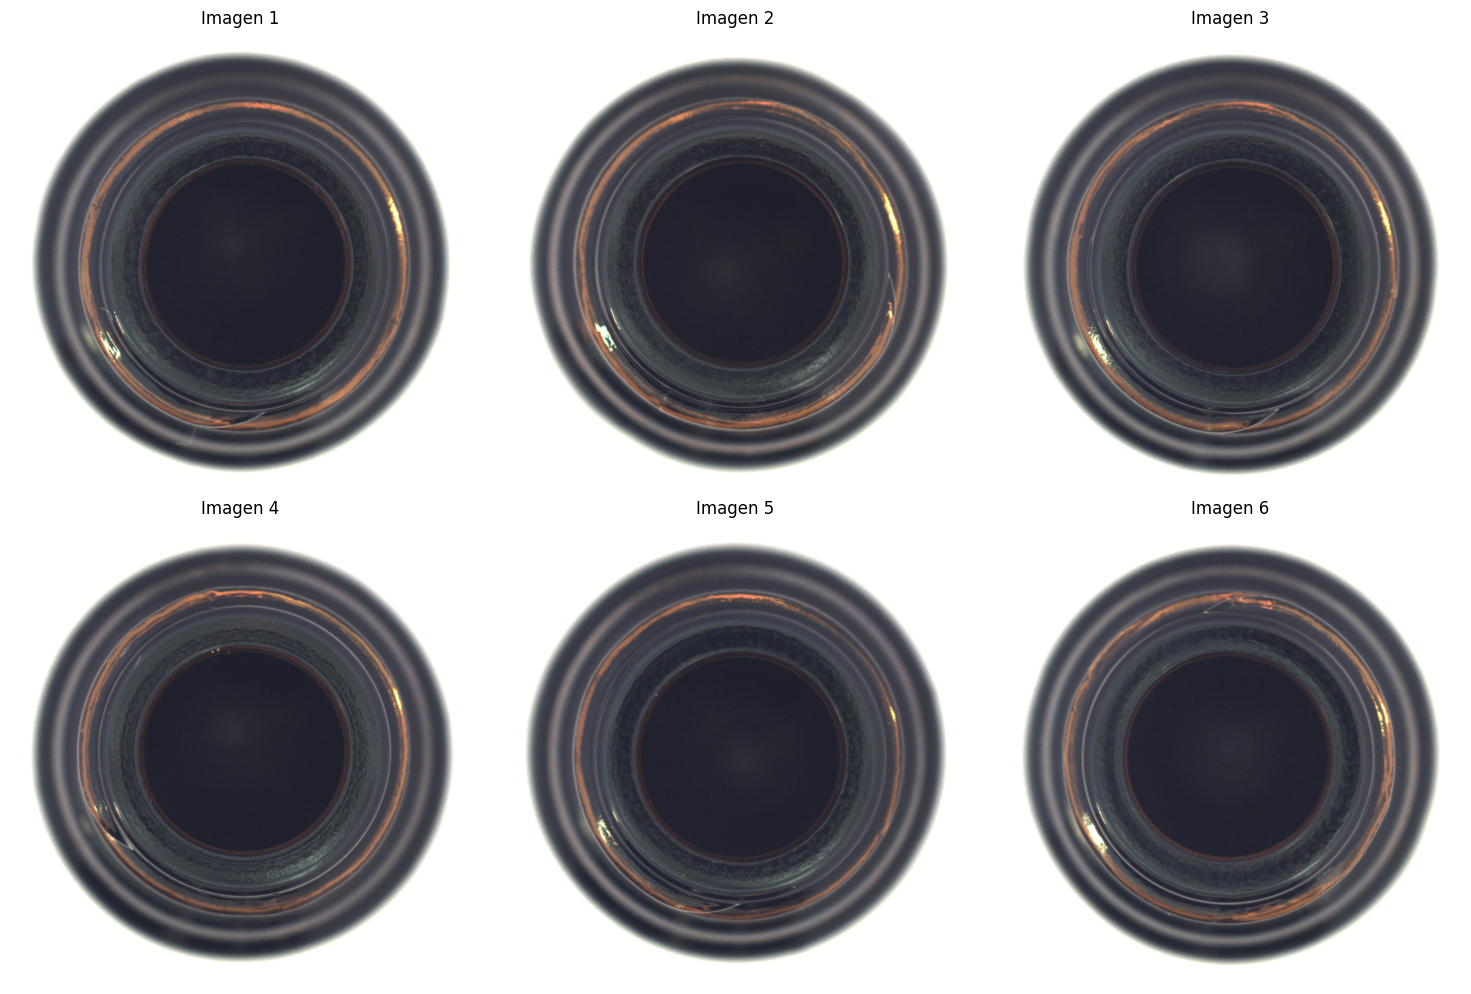

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(train_images[i])
    plt.title(f'Imagen {i+1}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [65]:
conv_encoder = keras.Sequential([
    Input(shape=(900, 900, 3)),
    Conv2D(filters=32, kernel_size=3, padding='same', activation='relu'), # 900 x 900 x 32
    MaxPooling2D(pool_size=(2, 2), padding='same'), # 450 x 450 x 32
    Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'), # 450 x 450 x 64
    MaxPooling2D(pool_size=(2, 2), padding='same'), # 225 x 225 x 64
    Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'), # 225 x 225 x 128
    MaxPooling2D(pool_size=(2, 2), padding='same'), # 113 x 113 x 128
    Conv2D(filters=70, kernel_size=3, padding='same', activation='relu'), # 113 x 113 x 70
    GlobalAvgPool2D() # 70
])

conv_decoder = keras.Sequential([
    Input(shape=(70,)),
    Dense(113 * 113 * 128, activation='relu'),
    Reshape((113, 113, 128)),
    Conv2DTranspose(filters=128, kernel_size=3, padding='same', activation='relu'),
    Conv2DTranspose(filters=64, kernel_size=3, strides=2, padding='same', activation='relu'),
    Conv2DTranspose(filters=32, kernel_size=3, strides=2, padding='same', activation='relu'),
    Conv2DTranspose(filters=3, kernel_size=3, strides=2, padding='same', activation='sigmoid'),
    Cropping2D(cropping=((2, 2), (2, 2))) # 900 x 900 x 3
])

conv_autoencoder = keras.Sequential([conv_encoder, conv_decoder])
conv_autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

In [66]:
test_input = np.array([train_images[0]])  # Añade batch dimension

# Ver dimensiones a través del encoder
print("ENCODER:")
x = test_input
for layer in conv_encoder.layers:
    x = layer(x)
    print(f"Después de {layer.__class__.__name__}: {x.shape}")

# Ver dimensiones a través del decoder
print("\nDECODER:")
x = conv_encoder(test_input)  # Obtener la codificación
for layer in conv_decoder.layers:
    x = layer(x)
    print(f"Después de {layer.__class__.__name__}: {x.shape}")

ENCODER:
Después de Conv2D: (1, 900, 900, 32)
Después de MaxPooling2D: (1, 450, 450, 32)
Después de Conv2D: (1, 450, 450, 64)
Después de MaxPooling2D: (1, 225, 225, 64)
Después de Conv2D: (1, 225, 225, 128)
Después de MaxPooling2D: (1, 113, 113, 128)
Después de Conv2D: (1, 113, 113, 70)
Después de GlobalAveragePooling2D: (1, 70)

DECODER:
Después de Dense: (1, 1634432)
Después de Reshape: (1, 113, 113, 128)
Después de Conv2DTranspose: (1, 113, 113, 128)
Después de Conv2DTranspose: (1, 226, 226, 64)
Después de Conv2DTranspose: (1, 452, 452, 32)
Después de Conv2DTranspose: (1, 904, 904, 3)
Después de Cropping2D: (1, 900, 900, 3)


In [67]:
conv_autoencoder.summary()

Model: "sequential_43"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential_41 (Sequential)      │ (None, 70)             │       173,958 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_42 (Sequential)      │ (None, 900, 900, 3)    │   116,285,379 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 116,459,337 (444.26 MB)

 Trainable params: 116,459,337 (444.26 MB)

 Non-trainable params: 0 (0.00 B)

In [68]:
def train(model, train_data, epochs=50, batch_size=8, validation_split=0.1):
    with tf.device('/GPU:0'):
        return model.fit(
            train_data, train_data,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=validation_split,
            shuffle=True
        )

In [69]:
history = train(conv_autoencoder, train_images, epochs=10, batch_size=16)

Epoch 1/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 0.1319 - val_loss: 0.1314
Epoch 2/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 24s 2s/step - loss: 0.1313 - val_loss: 0.1306
Epoch 3/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.1231 - val_loss: 0.0468
Epoch 4/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 28s 2s/step - loss: 0.0396 - val_loss: 0.0138
Epoch 5/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 27s 2s/step - loss: 0.0103 - val_loss: 0.0057
Epoch 6/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.0049 - val_loss: 0.0039
Epoch 7/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.0034 - val_loss: 0.0033
Epoch 8/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.0029 - val_loss: 0.0030
Epoch 9/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.0027 - val_loss: 0.0029
Epoch 10/10
12/12 ━━━━━━━━━━━━━━━━━━━━ 26s 2s/step - loss: 0.0026 - val_loss: 0.0028


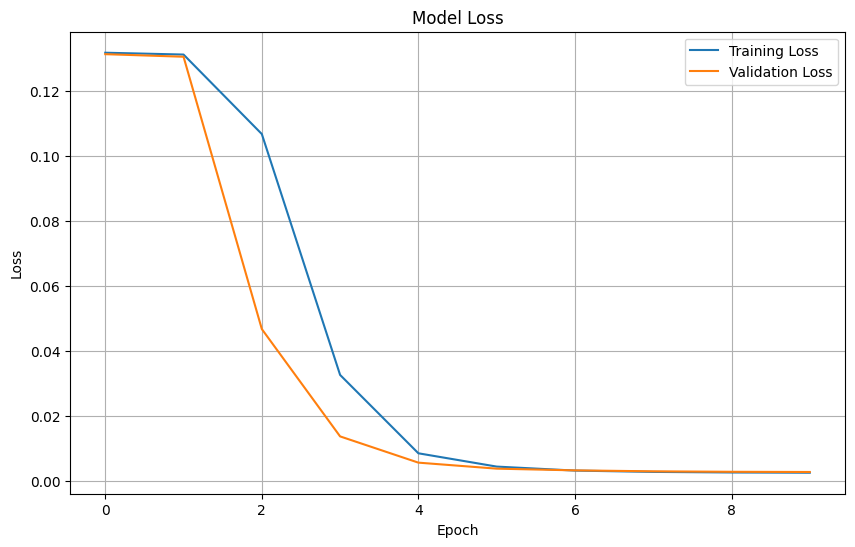

In [70]:
plt.figure(figsize=(10,6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [77]:
def show_reconstructions(model, data, label):
    reconstructions = model.predict(data)

    plt.figure(figsize=(15, 10))

    # Imágenes originales
    for i in range(6):
        plt.subplot(2, 6, i+1)
        plt.imshow(data[i])
        plt.title(f'{label} {i+1}')
        plt.axis('off')

    # Imágenes reconstruidas 
    for i in range(6):
        plt.subplot(2, 6, i+7)
        plt.imshow(reconstructions[i])
        plt.title(f'Reconstruida {i+1}')
        plt.axis('off')

    plt.tight_layout()
    plt.show()

    mse = np.mean((data - reconstructions) ** 2)
    print(f"\nError de reconstrucción promedio (MSE) {label}: {mse:.6f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 967ms/step


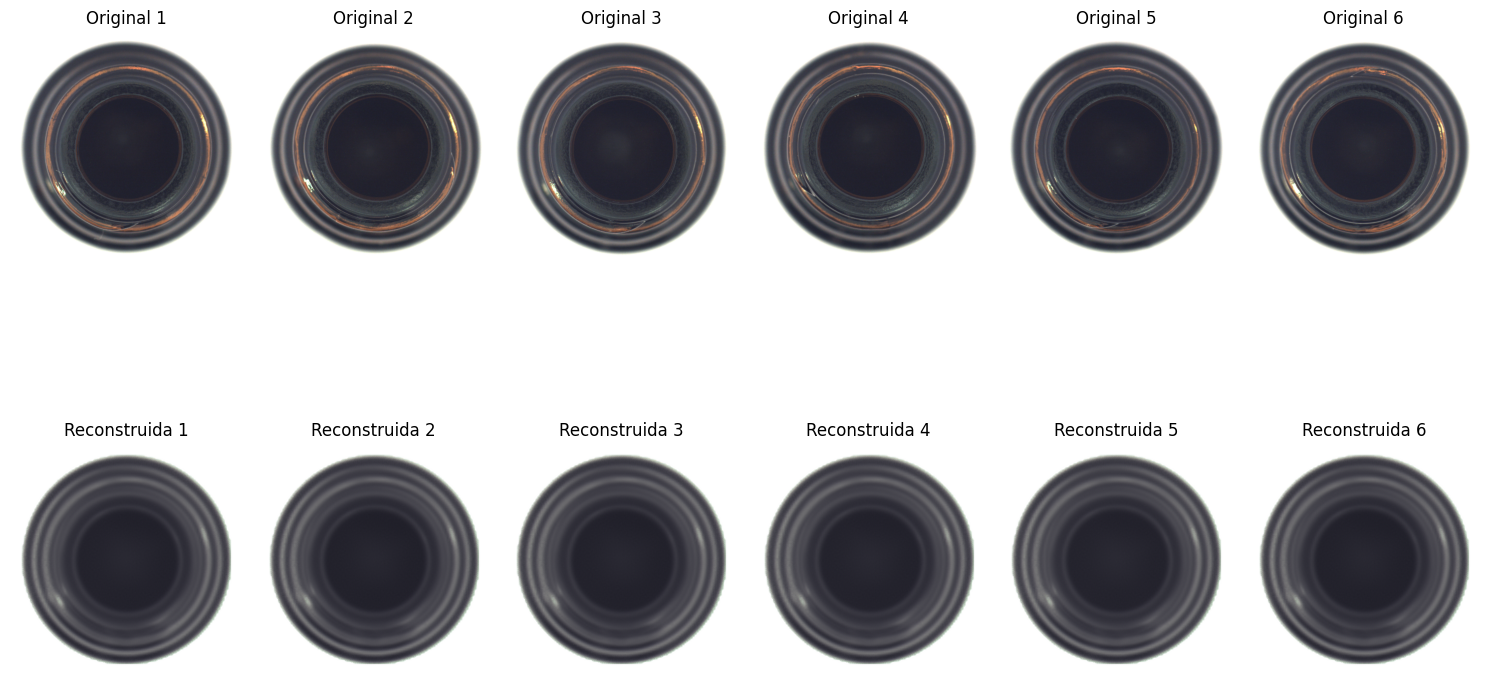


Error de reconstrucción promedio (MSE) Original: 0.002590


In [82]:
show_reconstructions(conv_autoencoder, train_images, 'Original')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 267ms/step


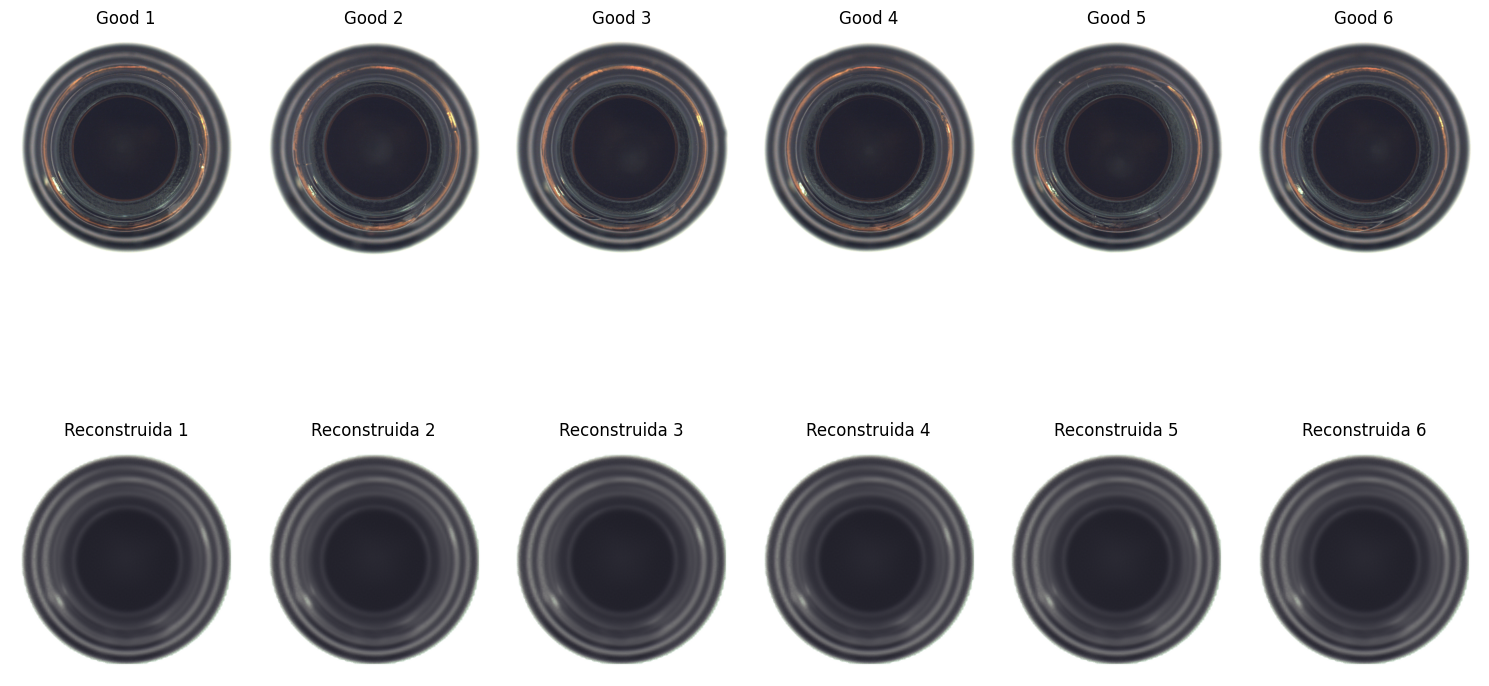


Error de reconstrucción promedio (MSE) Good: 0.002350


In [78]:
test_images_good = np.load('dataset/test_images_good.npy')
test_images_good = test_images_good / 255.0
show_reconstructions(conv_autoencoder, test_images_good[:6], 'Good')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 289ms/step


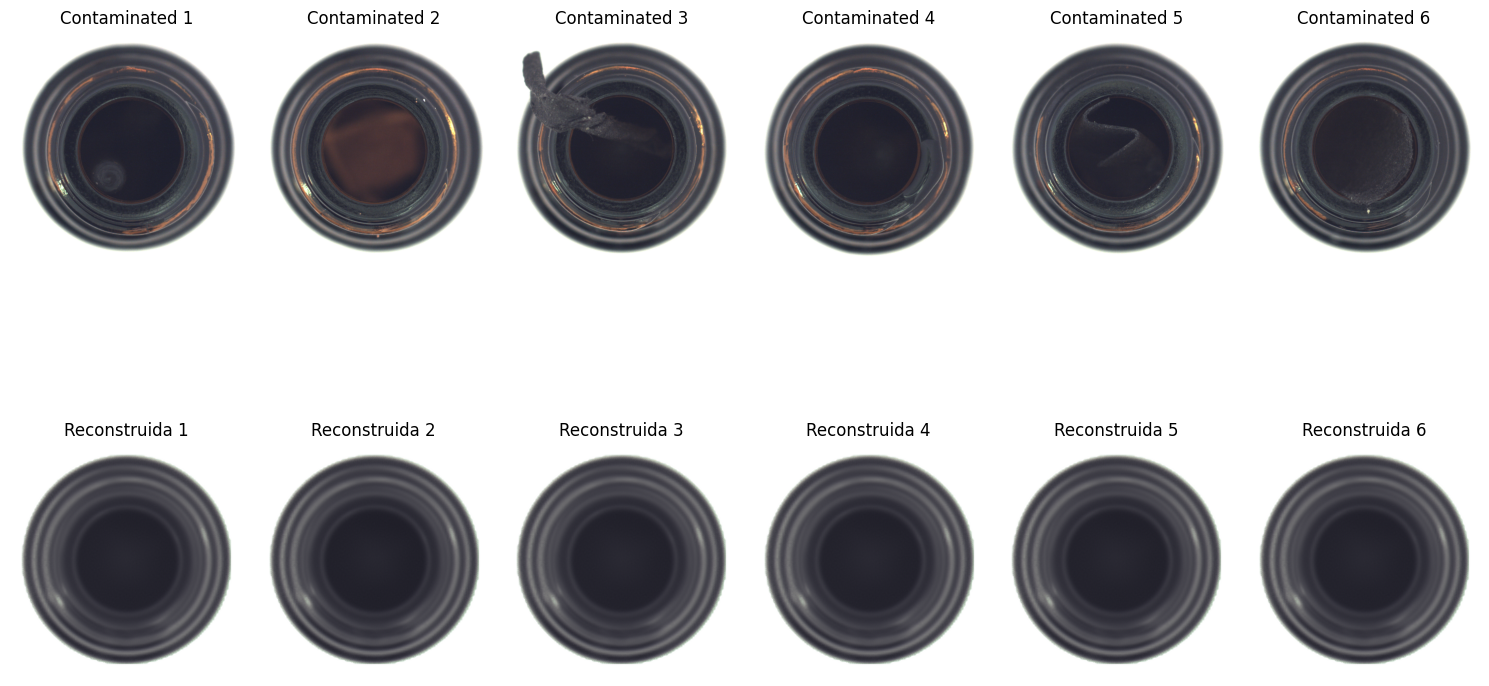


Error de reconstrucción promedio (MSE) Contaminated: 0.005187


In [79]:
test_images_contaminated = np.load('dataset/test_images_contamination.npy')
test_images_contaminated = test_images_contaminated / 255.0
show_reconstructions(conv_autoencoder, test_images_contaminated[:6], 'Contaminated')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 196ms/step


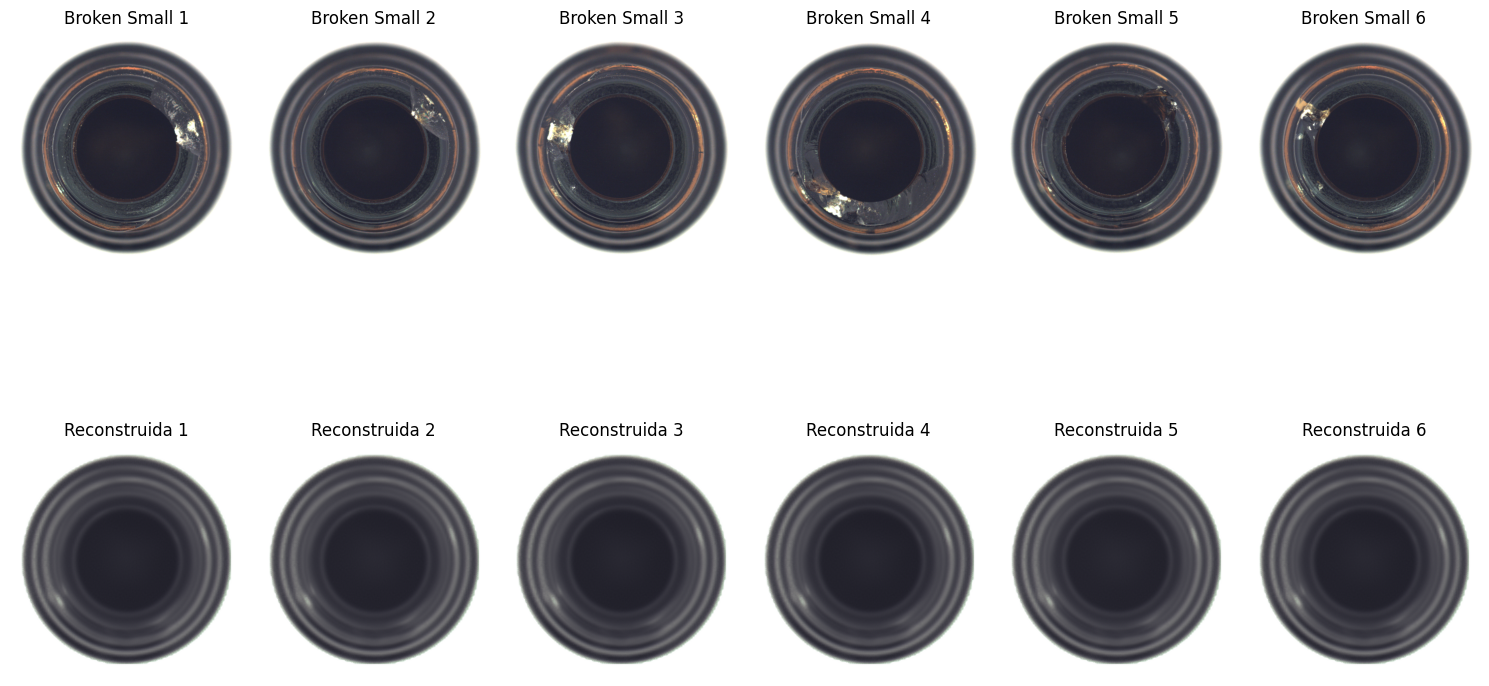


Error de reconstrucción promedio (MSE) Broken Small: 0.004170


In [80]:
test_images_broken_small = np.load('dataset/test_images_broken_small.npy')
test_images_broken_small = test_images_broken_small / 255.0
show_reconstructions(conv_autoencoder, test_images_broken_small[:6], 'Broken Small')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 201ms/step


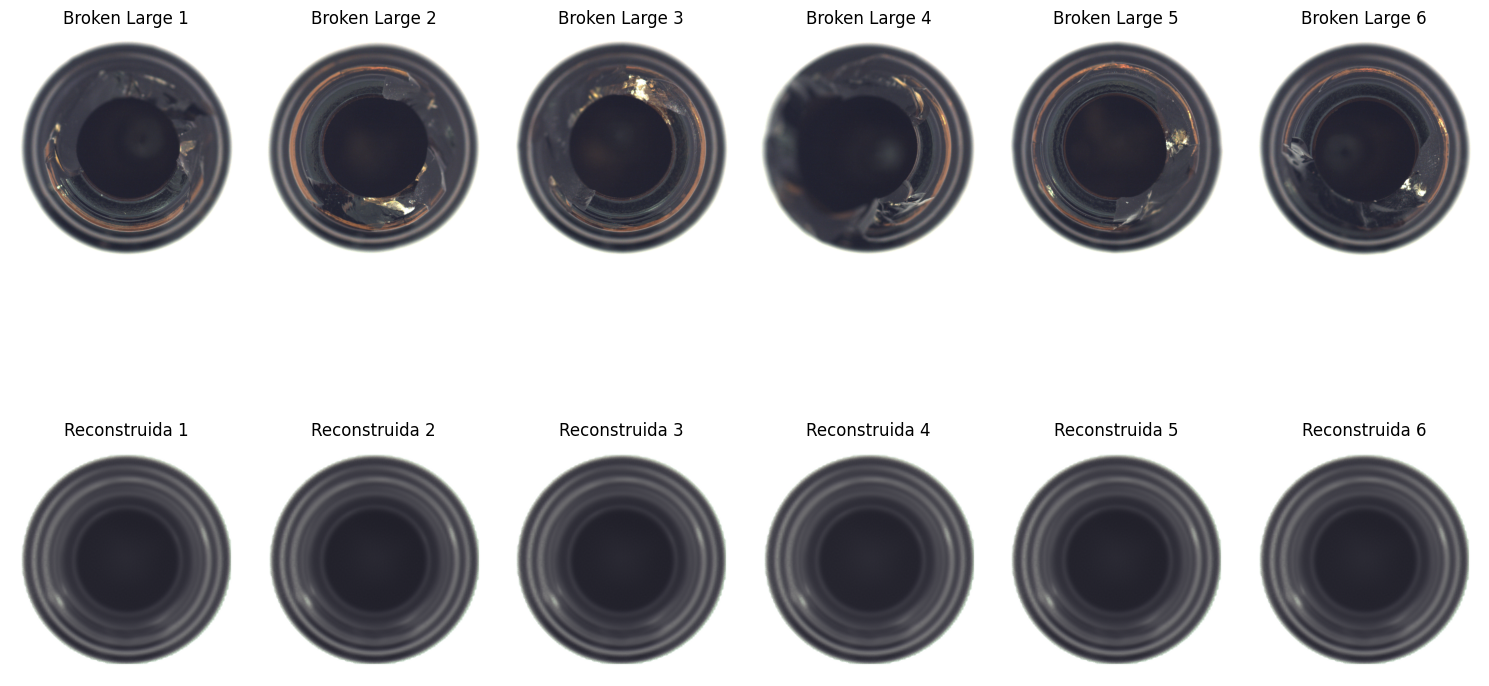


Error de reconstrucción promedio (MSE) Broken Large: 0.004618


In [81]:
test_images_broken_large = np.load('dataset/test_images_broken_large.npy')
test_images_broken_large = test_images_broken_large / 255.0
show_reconstructions(conv_autoencoder, test_images_broken_large[:6], 'Broken Large')

In [76]:
conv_autoencoder.save('autoencoder_anomaly_detection_bottle.keras')

In [93]:
# Calcular el umbral basado en MSE del set de entrenamiento
reconstructions = conv_autoencoder.predict(train_images)
mse_train = np.mean((train_images - reconstructions) ** 2, axis=(1,2,3))

7/7 ━━━━━━━━━━━━━━━━━━━━ 8s 945ms/step
Umbral calculado: 0.004318


In [170]:
threshold = np.mean(mse_train) + 1 * np.std(mse_train)
print(f"Umbral calculado: {threshold:.6f}")

Umbral calculado: 0.003454


In [171]:
def detect_anomalies(model, data, threshold=threshold):
    reconstructions = model.predict(data)
    mse = np.mean((data - reconstructions) ** 2, axis=(1, 2, 3))
    
    anomalies = mse > threshold
    return anomalies

In [172]:
from sklearn.metrics import accuracy_score

def evaluate_normal(model, data):
    predictions = detect_anomalies(model, data)

    targets = np.zeros(len(data), dtype=int)

    accuracy = accuracy_score(targets, predictions)
    
    fpr = predictions.sum() / len(predictions)

    print(f"Accuracy: {accuracy:.4f}") # Qué tan bien el modelo predice que las imágenes son normales.
    print(f"FPR: {fpr:.4f}") # Qué fracción de imágenes normales fueron mal etiquetadas como anómalas.

def evaluate_anomaly(model, data):
    predictions = detect_anomalies(model, data)

    targets = np.ones(len(data), dtype=int)

    accuracy = accuracy_score(targets, predictions)

    print(f"Accuracy: {accuracy:.4f}") # Qué tan bien el modelo predice que las imágenes son anómalas.

In [173]:
print("Test good images:")
evaluate_normal(conv_autoencoder, test_images_good)

Test good images:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 810ms/step
Accuracy: 0.9000
FPR: 0.1000


In [174]:
print("Test contaminated images:")
evaluate_anomaly(conv_autoencoder, test_images_contaminated)

Test contaminated images:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 749ms/step
Accuracy: 0.7143


In [175]:
print("Test broken small images:")
evaluate_anomaly(conv_autoencoder, test_images_broken_small)

Test broken small images:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 889ms/step
Accuracy: 0.5909


In [176]:
print("Test broken large images:")
evaluate_anomaly(conv_autoencoder, test_images_broken_large)

Test broken large images:
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 599ms/step
Accuracy: 0.7000


In [177]:
good_images = test_images_good
anomaly_images = np.concatenate([test_images_contaminated, test_images_broken_small, test_images_broken_large])

good_images_targets = np.zeros(len(good_images), dtype=int)
anomaly_images_targets = np.ones(len(anomaly_images), dtype=int)

all_images = np.concatenate([good_images, anomaly_images])
all_targets = np.concatenate([good_images_targets, anomaly_images_targets])

predictions = detect_anomalies(conv_autoencoder, all_images)

accuracy = accuracy_score(all_targets, predictions)

print(f"Accuracy: {accuracy:.4f}")

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 891ms/step
Accuracy: 0.7229
